### 🔥 Train ResNet-50 on Synthetic-Only Dataset (Yunnan)

This notebook trains a binary fire classification model using only synthetic fire images from the **Yunnan University dataset** (Unreal Engine 5–rendered).

We replicate the same training strategy used for the real D-Fire dataset, but using only the synthetic data. The goal is to evaluate how well a model trained **solely on synthetic images** performs on the real-world test set (D-Fire).

📌 Key Features:
- Uses **FireClassificationSyntheticDataset** from `fire_classification_dataset.py`
- Backbone: **ResNet-50 (ImageNet pretrained)**
- Only the final fully-connected layer is trained (feature extraction)
- Results will be compared directly against the baseline model (`resnet_real_100.pt`)
- Final model checkpoint will be saved as: `resnet_syn_100.pt`

This notebook contributes to the core experimental comparison:  
**Real-Only vs Synthetic-Only vs Mixed Training Composition**


## 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is reproducible in any new Colab session by:

- Mounting your Google Drive (to access datasets, secrets, and checkpoints)
- Loading your GitHub token from Drive
- Cloning the fire-detection-dissertation repository
- Navigating into the correct folder
- Setting Git identity for future commits

⚠️ **Note:** This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔧 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 60 (delta 26), reused 43 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 448.39 KiB | 11.21 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/fire-detection-dissertation


### 📁 Step 1 – Load and Inspect the Synthetic Dataset (Yunnan)

In this step, we load the synthetic fire image dataset created by Yunnan University using Unreal Engine 5. This dataset includes both fire and non-fire (e.g. smoke or no fire) images with bounding box annotations in YOLO format.

We will use the custom `FireClassificationSyntheticDataset` class from `fire_classification_dataset.py` to load the data. This class handles label remapping specific to the synthetic dataset:

- **Class 0 (fire)** → **binary label 1** 🔥  
- **Class 1 (non-fire / smoke)** → **binary label 0** 💨

⚠️ This mapping is the **inverse of the real D-Fire dataset**, which uses a different dataset class (`FireClassificationDataset`) with its own label logic.

In this step, we will:
- Define paths to the image and label directories
- Load the dataset with resizing and tensor transformations
- Print the total dataset size
- Randomly visualise 5 samples with their assigned binary labels to confirm label logic and image integrity


✅ Total samples in synthetic dataset: 3946


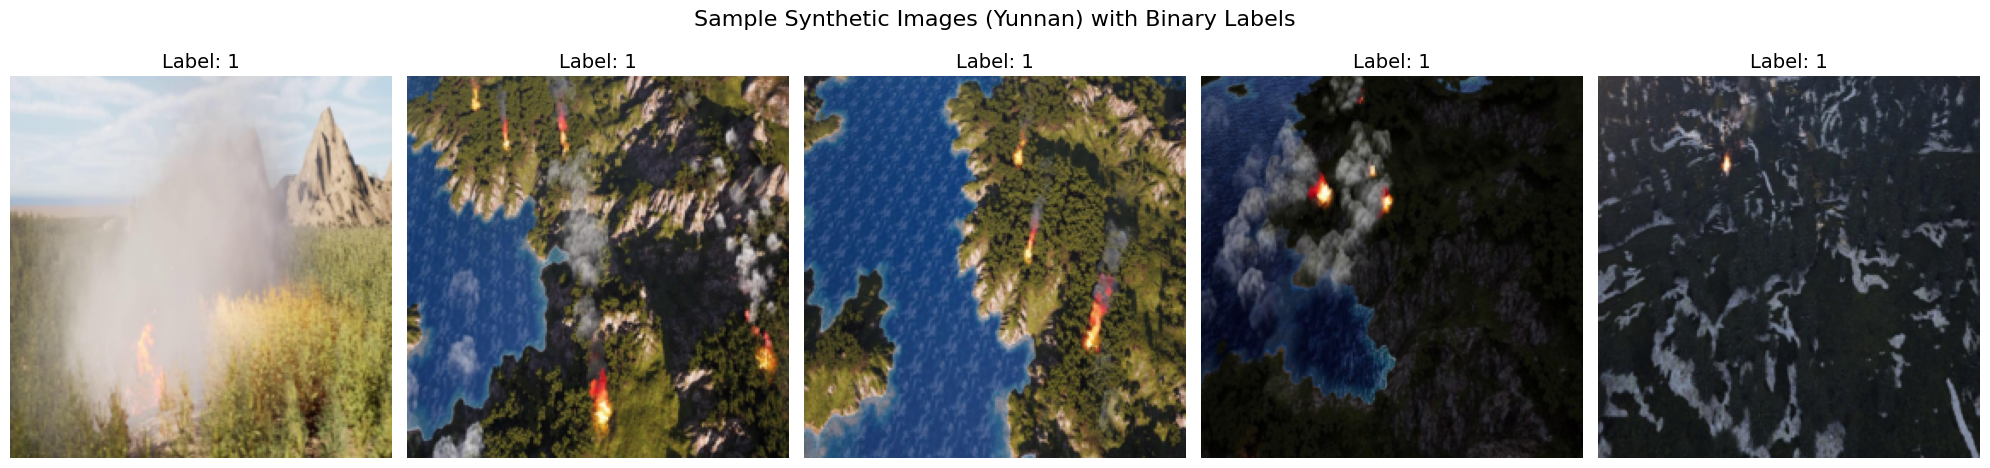

In [2]:
# Step 1 – Load and Inspect the Synthetic Dataset

# Import required modules
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from utils.fire_classification_dataset import FireClassificationSyntheticDataset

# Define paths to synthetic images and labels in Google Drive
image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images"
label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels"

# Define transform: Resize all images to 224x224 and convert them to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Initialise the custom dataset class for synthetic data
synthetic_dataset = FireClassificationSyntheticDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=transform
)

# Print total number of samples in the dataset
print(f"✅ Total samples in synthetic dataset: {len(synthetic_dataset)}")

# Visualise 5 random samples to confirm label mapping and image quality
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    idx = random.randint(0, len(synthetic_dataset) - 1)
    image, label = synthetic_dataset[idx]

    # Convert tensor to image format for display (CHW → HWC)
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f"Label: {int(label)}", fontsize=14)
    axs[i].axis("off")

plt.suptitle("Sample Synthetic Images (Yunnan) with Binary Labels", fontsize=16)
plt.tight_layout()
plt.show()


### ⚙️ Step 2 – Prepare Data Loaders and Training Configuration

In this step, we split the Yunnan synthetic dataset into training and validation subsets and prepare PyTorch DataLoaders for each.

We also define:
- The model architecture: **ResNet-50**, pretrained on ImageNet
- Loss function: **CrossEntropyLoss** (suitable for multi-class, including binary tasks)
- Optimizer: **Adam**, learning rate 1e-4
- Number of epochs and batch size
- File path to save the best-performing model (based on F1 score)

These configurations mirror those used in the real-only baseline experiment, ensuring a fair comparison between training compositions.


In [3]:
# Step 2 – Prepare Data Loaders and Training Configuration

import torch
from torch import nn, optim
from torchvision import models
from torch.utils.data import random_split, DataLoader

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# Define dataset size split (80% train, 20% validation)
train_size = int(0.8 * len(synthetic_dataset))
val_size = len(synthetic_dataset) - train_size
train_dataset, val_dataset = random_split(synthetic_dataset, [train_size, val_size])

print(f"📊 Dataset split → Train: {train_size}, Validation: {val_size}")

# Define DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load ResNet-50 model and modify the final fully connected layer
model = models.resnet50(pretrained=True)

# Freeze all layers except the final FC layer (optional – could unfreeze later)
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer for binary classification (2 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# Define number of epochs and save path
num_epochs = 5
save_path = "/content/drive/MyDrive/fire-detection-dissertation/models/resnet_synthetic_100.pt"

print("✅ Model, DataLoaders, and training configuration are ready.")


🖥️ Using device: cuda
📊 Dataset split → Train: 3156, Validation: 790


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


✅ Model, DataLoaders, and training configuration are ready.


### 🔥 Step 3 – Train the Model on Synthetic-Only Dataset

In this step, we train a **ResNet-50** model on the synthetic fire dataset using our reusable training helper function: `train_model()` from `train_utils.py`.

The model is trained for 5 epochs using the following settings:
- **Loss function**: CrossEntropyLoss (standard for classification)
- **Optimizer**: Adam (learning rate = 1e-4)
- **Device**: GPU (if available)
- **Best checkpoint** is selected based on validation F1 score and saved to Drive

Training and validation losses are logged for every epoch. This will later allow us to compare performance across training compositions (real-only, synthetic-only, mixed).


In [5]:
# Step 3 – Train the Model on Synthetic-Only Dataset

from utils.train_model import train_model

# Run training loop using helper function
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,  # match baseline
    device=device,
    save_path=save_path,
    print_every=1,  # print epoch summary every time
    print_batch_loss=False  # set True if you want per-batch updates
)



🔍 Model device: cuda:0

🔁 Epoch 1/5


✅ Epoch [1/5] | Train Loss: 0.4042 | Val Loss: 0.3204 | Acc: 0.8544 | Precision: 0.8529 | Recall: 1.0000 | F1: 0.9206 | Time: 1383.0s
💾 New best model saved (F1: 0.9206) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_synthetic_100.pt

🔁 Epoch 2/5


✅ Epoch [2/5] | Train Loss: 0.3112 | Val Loss: 0.2842 | Acc: 0.8911 | Precision: 0.9029 | Recall: 0.9760 | F1: 0.9380 | Time: 63.5s
💾 New best model saved (F1: 0.9380) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_synthetic_100.pt

🔁 Epoch 3/5


✅ Epoch [3/5] | Train Loss: 0.2728 | Val Loss: 0.2559 | Acc: 0.8975 | Precision: 0.9150 | Recall: 0.9685 | F1: 0.9410 | Time: 60.7s
💾 New best model saved (F1: 0.9410) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_synthetic_100.pt

🔁 Epoch 4/5


✅ Epoch [4/5] | Train Loss: 0.2532 | Val Loss: 0.2381 | Acc: 0.9013 | Precision: 0.9051 | Recall: 0.9865 | F1: 0.9440 | Time: 62.6s
💾 New best model saved (F1: 0.9440) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_synthetic_100.pt

🔁 Epoch 5/5


✅ Epoch [5/5] | Train Loss: 0.2397 | Val Loss: 0.2313 | Acc: 0.9190 | Precision: 0.9401 | Recall: 0.9655 | F1: 0.9527 | Time: 62.0s
💾 New best model saved (F1: 0.9527) → /content/drive/MyDrive/fire-detection-dissertation/models/resnet_synthetic_100.pt


In [7]:
# Step 1: Navigate to your cloned Git repo
%cd /content/fire-detection-dissertation

# Step 2: Move the notebook from Drive into the repo (this makes Git track it)
!mv /content/drive/MyDrive/fire-detection-dissertation/notebooks/04_train_resnet_synthetic_only.ipynb /content/fire-detection-dissertation/notebooks/

# Step 3: Confirm it has moved
!ls notebooks/

# Step 4: Add to Git
!git add notebooks/04_train_resnet_synthetic_only.ipynb

# Step 5: Commit with message
!git commit -m "Added initial synthetic-only training notebook (ResNet-50 on Yunnan dataset)"

# Step 6: Push to GitHub
!git push


/content/fire-detection-dissertation
mv: cannot stat '/content/drive/MyDrive/fire-detection-dissertation/notebooks/04_train_resnet_synthetic_only.ipynb': No such file or directory
01_setup_environment.ipynb   03_train_resnet_real_only.ipynb
02_data_preprocessing.ipynb  evaluate_models.ipynb
fatal: pathspec 'notebooks/04_train_resnet_synthetic_only.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date
